# Prophet

In [ ]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np
import pickle
import optuna

## Load data

In [76]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1577,2025-02-18,1359.0,11832.0,11.485801,849375.0,False,False
1578,2025-02-19,1190.0,11835.0,10.054922,743750.0,False,False
1579,2025-02-20,1207.0,11990.0,10.066722,754375.0,False,False
1580,2025-02-21,1110.0,11907.0,9.322247,693750.0,False,False


## Prophet

In [77]:
df = df[['Date', 'Revenue Losses', 'Train', 'Outlier']].rename(columns={'Revenue Losses': 'y', 'Date': 'ds'})
df

,ds,y,Train,Outlier
0,2020-10-25,221250.0,True,False
1,2020-10-26,233125.0,True,False
2,2020-10-27,266875.0,True,False
3,2020-10-28,244375.0,True,False
4,2020-10-29,233750.0,True,False
...,...,...,...,...
1577,2025-02-18,849375.0,False,False
1578,2025-02-19,743750.0,False,False
1579,2025-02-20,754375.0,False,False
1580,2025-02-21,693750.0,False,False


In [78]:
# Box-Cox Transformation on cases where Outlier is False and is not missing
orig_df = df.copy() # save original df for later plots
no_out_missing = df[(df['Outlier'] == False) & (df['y'].notnull())]
no_out_missing['y'], lam = stats.boxcox(no_out_missing['y'])
df.loc[no_out_missing.index, 'y'] = no_out_missing['y']
print(f'Lambda: {lam}')

# Save lam to pickle
with open('Models/Prophet_lam.pkl', 'wb') as f:
    pickle.dump(lam, f)

Lambda: 1.6226069096310194


C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\1737381420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_out_missing['y'], lam = stats.boxcox(no_out_missing['y'])


In [79]:
# Add a column of indicators for each row to indicate whether the row is an outlier
# This might not be super necessary since prophet is generally robust, but some of these are rather extreme
outlier_cols = []
for i in range(len(df)):
    if df.loc[i, 'Outlier'] == 1:
        df['Outlier_' + str(df['ds'][i])] = [1 if j == i else 0 for j in range(len(df))]
        outlier_cols.append('Outlier_' + str(df['ds'][i]))
df

C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\4004347482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Outlier_' + str(df['ds'][i])] = [1 if j == i else 0 for j in range(len(df))]
C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\4004347482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Outlier_' + str(df['ds'][i])] = [1 if j == i else 0 for j in range(len(df))]
C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\4004347482.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

,ds,y,Train,Outlier,Outlier_2020-12-14 00:00:00,Outlier_2021-07-07 00:00:00,Outlier_2021-07-08 00:00:00,Outlier_2021-07-09 00:00:00,Outlier_2021-07-10 00:00:00,Outlier_2021-07-11 00:00:00,...,Outlier_2024-09-01 00:00:00,Outlier_2024-09-02 00:00:00,Outlier_2024-09-03 00:00:00,Outlier_2024-09-04 00:00:00,Outlier_2024-09-05 00:00:00,Outlier_2024-09-06 00:00:00,Outlier_2024-09-07 00:00:00,Outlier_2024-09-08 00:00:00,Outlier_2024-09-09 00:00:00,Outlier_2024-11-15 00:00:00
0,2020-10-25,2.900222e+08,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-10-26,3.156992e+08,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-10-27,3.931437e+08,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-10-28,3.407884e+08,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-10-29,3.170737e+08,True,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2025-02-18,2.572672e+09,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1578,2025-02-19,2.073980e+09,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1579,2025-02-20,2.122269e+09,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1580,2025-02-21,1.852520e+09,False,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Train/test split
train_df = df.query('Train == 1').drop(columns = ['Train', 'Outlier'])
test_df = df.query('Train == 0').drop(columns = ['Train', 'Outlier'])
print(len(train_df), len(test_df))
train_df

1552 30


,ds,y,Outlier_2020-12-14 00:00:00,Outlier_2021-07-07 00:00:00,Outlier_2021-07-08 00:00:00,Outlier_2021-07-09 00:00:00,Outlier_2021-07-10 00:00:00,Outlier_2021-07-11 00:00:00,Outlier_2021-07-12 00:00:00,Outlier_2021-07-13 00:00:00,...,Outlier_2024-09-01 00:00:00,Outlier_2024-09-02 00:00:00,Outlier_2024-09-03 00:00:00,Outlier_2024-09-04 00:00:00,Outlier_2024-09-05 00:00:00,Outlier_2024-09-06 00:00:00,Outlier_2024-09-07 00:00:00,Outlier_2024-09-08 00:00:00,Outlier_2024-09-09 00:00:00,Outlier_2024-11-15 00:00:00
0,2020-10-25,2.900222e+08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-10-26,3.156992e+08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-10-27,3.931437e+08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-10-28,3.407884e+08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-10-29,3.170737e+08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,2025-01-19,3.029399e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1548,2025-01-20,3.459003e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1549,2025-01-21,3.397274e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1550,2025-01-22,2.925440e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Going with the most commonly tuned items for seasonality and changepoint priors
# We should also tune the changepoint range since this is a long time series
def objective(trial):
    param_grid = {
        "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.001, 0.5),
        "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.01, 10.0),
        "changepoint_range": trial.suggest_float("changepoint_range", 0.5, 1.0)
    }

    m = Prophet(**param_grid)
    # Add outlier columns
    for col in outlier_cols:
        m.add_regressor(col)

    # Typical last 30 days validation set
    # Could do cross-validation, but since we are varying changepoint_range which will be dependent on train set size, might as well do this
    obj_df_train = train_df[:-30]
    obj_df_val = train_df[-30:]

    m.fit(obj_df_train)
    forecast = m.predict(obj_df_val)
    rmse = root_mean_squared_error(obj_df_val['y'], forecast['yhat'])

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=1800)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

optimal_changepoint_prior = study.best_params['changepoint_prior_scale']
optimal_seas_prior = study.best_params['seasonality_prior_scale']
optimal_changepoint_range = study.best_params['changepoint_range']

[I 2025-02-23 09:55:01,811] A new study created in memory with name: no-name-1ad36d0e-1fa9-4639-9390-40f04f082c70
09:55:02 - cmdstanpy - INFO - Chain [1] start processing
09:55:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\prophet\forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)
[I 2025-02-23 09:55:03,139] Trial 0 finished with value: 380916495.73800486 and parameters: {'changepoint_prior_scale': 0.12481781326328852, 'seasonality_prior_scale': 2.424360559330887, 'changepoint_range': 0.7722503964501899}. Best is trial 0 with value: 380916495.73800486.
09:55:03 - cmdstanpy - INFO - Chain [1] start processing
09:55:04 - c

Best hyperparameters: {'changepoint_prior_scale': 0.15128457320116792, 'seasonality_prior_scale': 1.2640476524227584, 'changepoint_range': 0.7606212426321627}
Best RMSE: 376929839.9681475


09:57:08 - cmdstanpy - INFO - Chain [1] start processing
09:57:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\2443219281.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\2443219281.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\iliu\AppData\Local\Temp\ipykernel_14656\2443219281.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usu

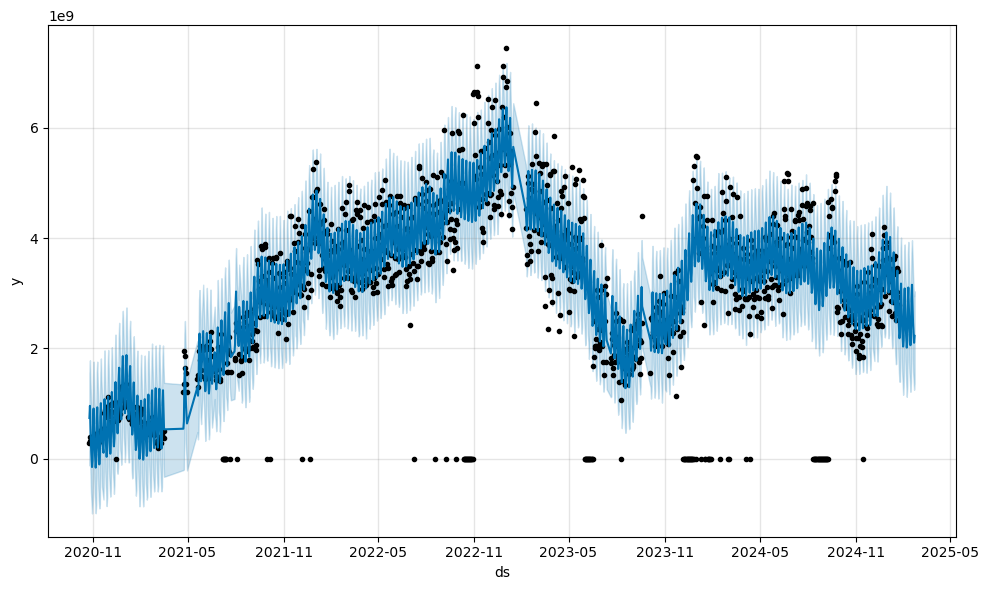

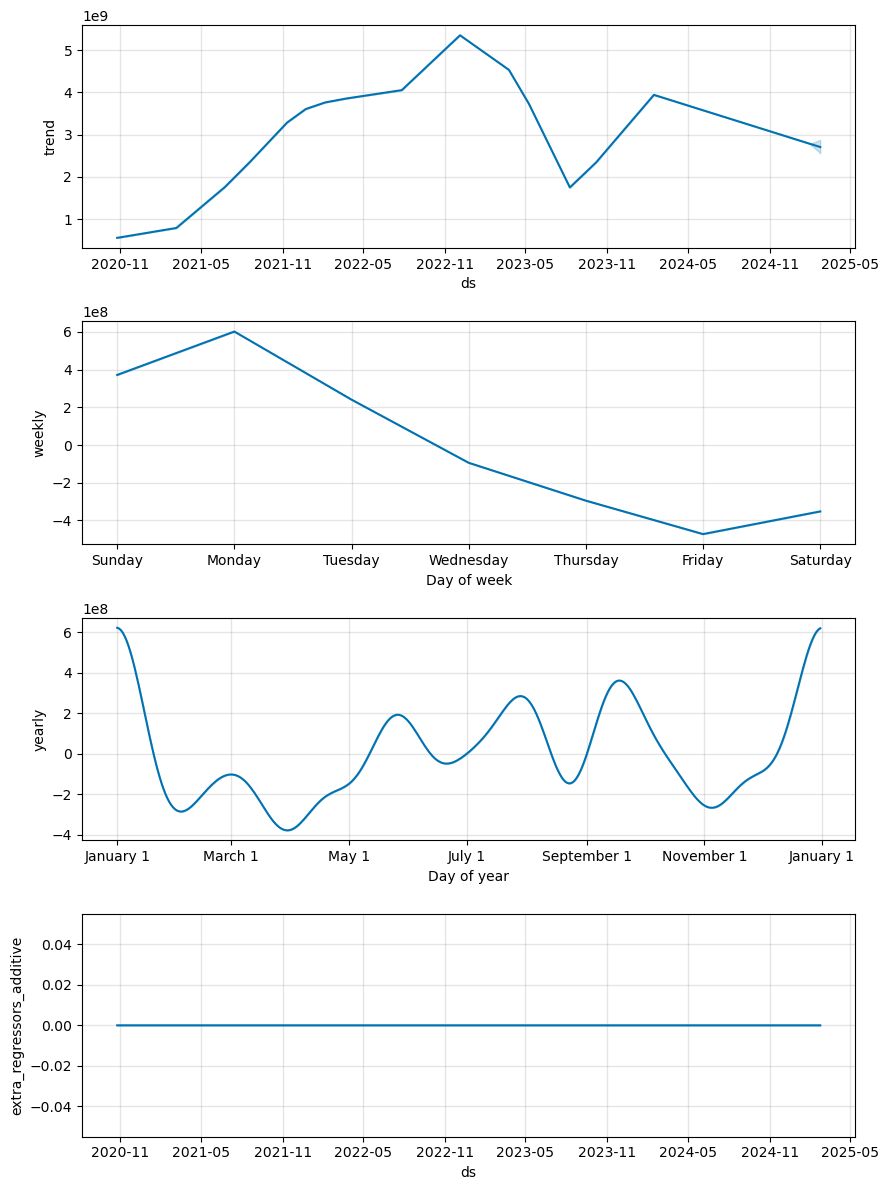

In [82]:
# Fit model
m = Prophet(
    interval_width=0.95, # standard intervals
    seasonality_prior_scale=optimal_seas_prior,
    changepoint_prior_scale=optimal_changepoint_prior,
    changepoint_range=optimal_changepoint_range
)

# Add outlier columns
for col in outlier_cols:
    m.add_regressor(col)

m.fit(train_df)

future = m.make_future_dataframe(periods=30)

for col in outlier_cols:
    future[col] = [0] * len(future)

forecast = m.predict(future)

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

In [83]:
# Save model to disk
with open('Models/Prophet.pkl', 'wb') as pkl:
    pickle.dump(m, pkl)

In [84]:
# Undo-Box-Cox everywhere
forecast['yhat'] = inv_boxcox(forecast['yhat'], lam)
forecast['yhat_lower'] = inv_boxcox(forecast['yhat_lower'], lam)
forecast['yhat_upper'] = inv_boxcox(forecast['yhat_upper'], lam)
df['y'] = inv_boxcox(df['y'], lam)
train_df_bc = train_df.copy() # save transformed version of train_df
train_df['y'] = inv_boxcox(train_df['y'], lam)
test_df['y'] = inv_boxcox(test_df['y'], lam)

In [85]:
# Check residuals
def plot_prophet_residuals(m, df, lam, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for Prophet.

    Args:
        m: The fitted Prophet model object.
        df: The original DataFrame used to fit the model.
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    forecast = m.predict(df)
    df['residuals'] = df['y'] - forecast['yhat']
    residuals = df['residuals']
    fitted_values = forecast['yhat']  # Use predicted values

    # # undo box-cox
    # residuals = inv_boxcox(residuals, lam)
    # fitted_values = inv_boxcox(fitted_values, lam)
    # df['y'] = inv_boxcox(df['y'], lam)
    # df['residuals'] = residuals

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(df['ds'], residuals) # Plot against 'ds' (date)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1], title='Autocorrelation Function (ACF)') # Set title here
    #axes[1, 1].set_title('Autocorrelation Function (ACF)')  # No need to set title separately

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2, 1])  # Remove the empty subplot

    plt.tight_layout()
    plt.show()


c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\prophet\forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


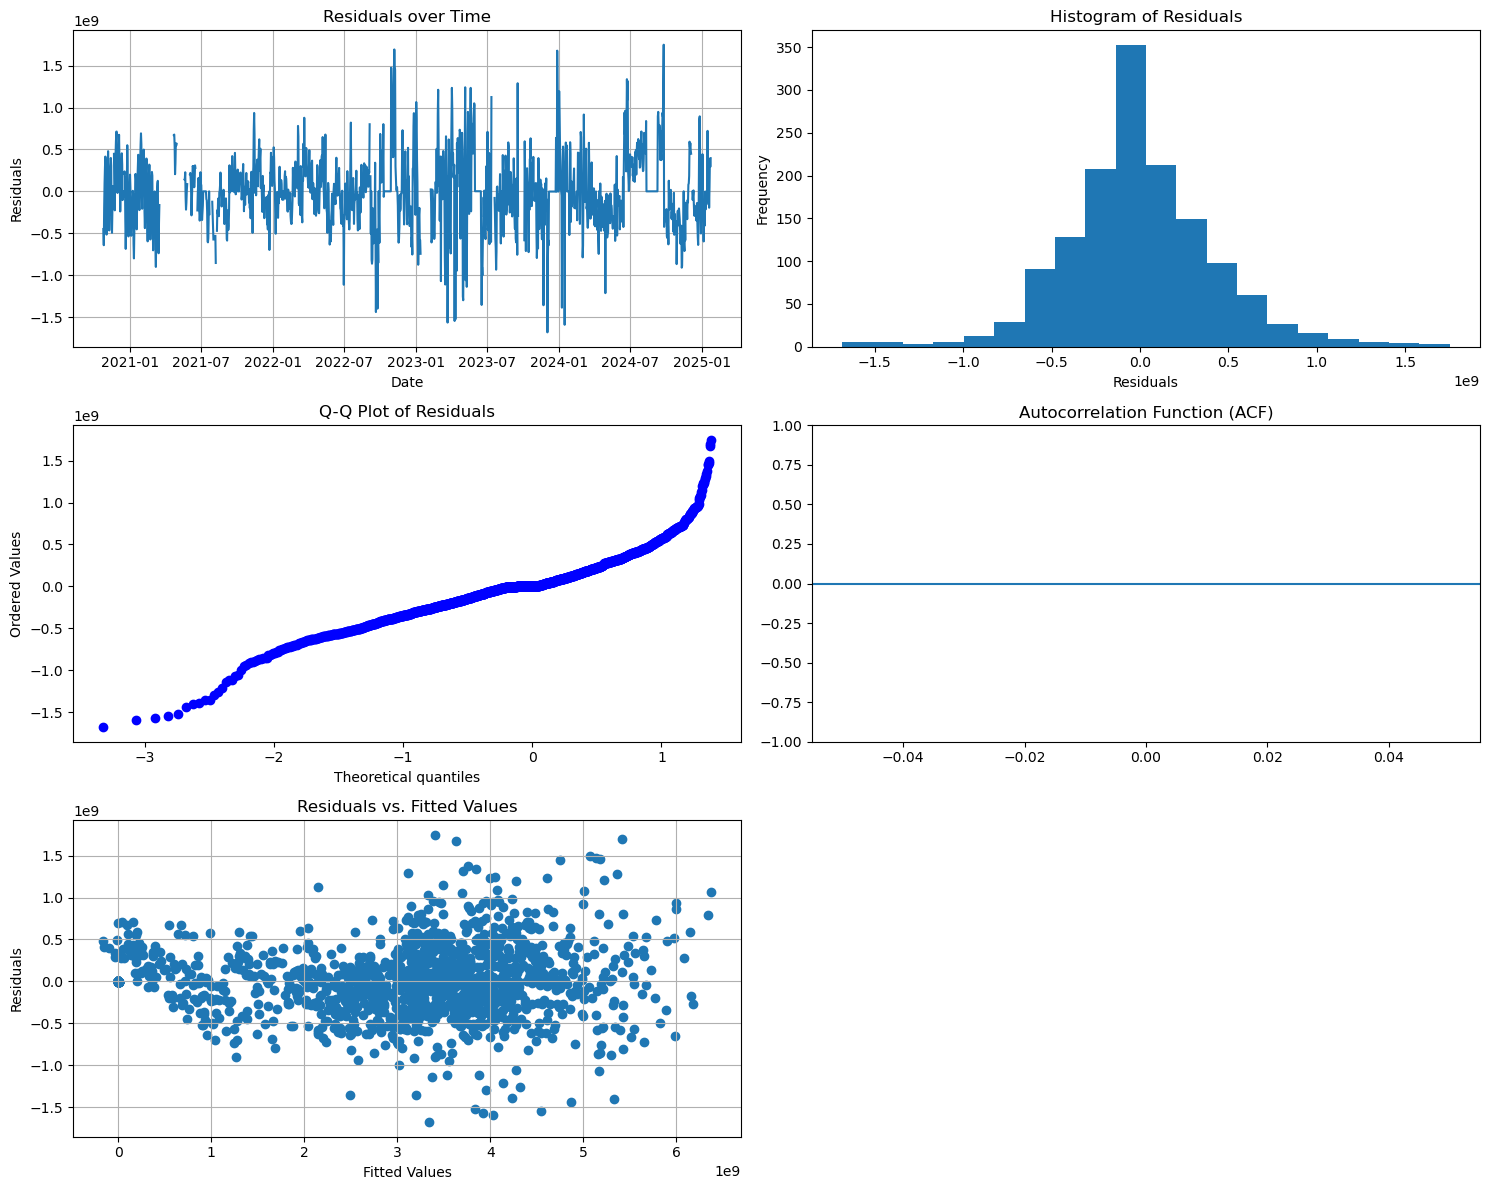

In [86]:
plot_prophet_residuals(m, train_df_bc, lam)

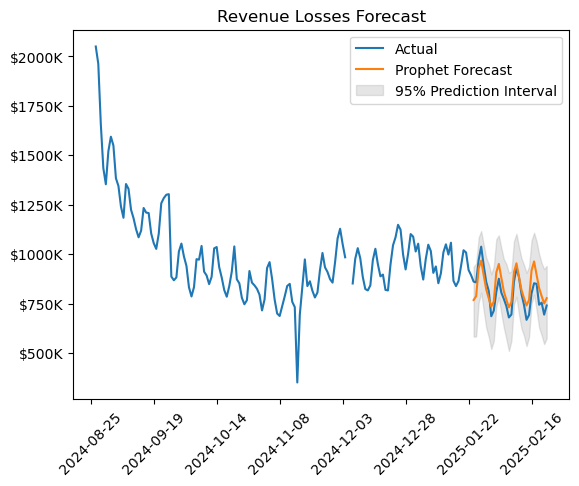

MAE: 56209.591968186905
RMSE: 62195.03860783866
MAPE: 7.09140627655187


In [87]:
plt.plot(orig_df['y'][-180:], label="Actual")
plt.plot(df.index[-len(test_df):], forecast['yhat'][-len(test_df):], label="Prophet Forecast")
# Add prophet prediction intervals
plt.fill_between(df.index[-len(test_df):], forecast['yhat_lower'][-len(test_df):], forecast['yhat_upper'][-len(test_df):], color='gray', alpha=0.2, label='95% Prediction Interval')
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['ds'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['y'], forecast['yhat'][-len(test_df):])
rmse = root_mean_squared_error(test_df['y'], forecast['yhat'][-len(test_df):])
print('MAE:', mae)
print('RMSE:', rmse)
# Also compute MAPE for reporting
mape = np.mean(np.abs((np.array(test_df['y']) - np.array(forecast['yhat'][-len(test_df):])) / np.array(test_df['y'])) * 100)
print('MAPE:', mape)

In [88]:
# 7-day seasonal naive forecast for comparison
last_7 = list(train_df['y'][-7:])
seasonal_naive_forecast = [last_7[i % 7] for i in range(len(test_df))]
# Set index of dates to be that of test_df
seasonal_naive_forecast_df = pd.DataFrame(seasonal_naive_forecast, index=test_df.index, columns=['y'])

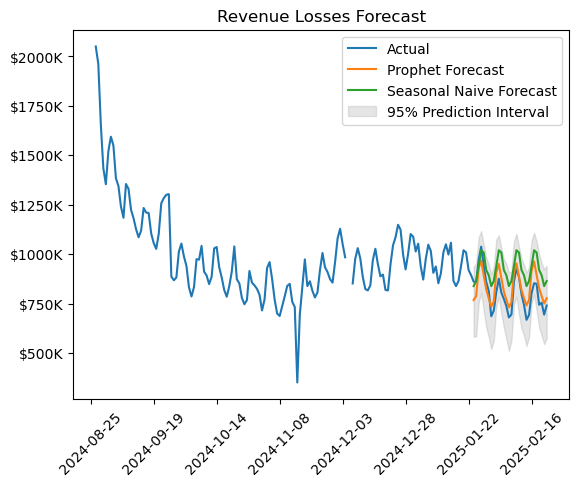

Seasonal Naive MAE: 121687.49999999949
Seasonal Naive RMSE: 132294.89825449264
Seasonal Naive MAPE: 15.838210192694474


In [89]:
# PLot with seasonal naive forecast
plt.plot(orig_df['y'][-180:], label="Actual")
plt.plot(df.index[-len(test_df):], forecast['yhat'][-len(test_df):], label="Prophet Forecast")
# Seasonal naive forecast
plt.plot(df.index[-len(test_df):], seasonal_naive_forecast_df['y'], label="Seasonal Naive Forecast")
# Add prophet prediction intervals
plt.fill_between(df.index[-len(test_df):], forecast['yhat_lower'][-len(test_df):], forecast['yhat_upper'][-len(test_df):], color='gray', alpha=0.2, label='95% Prediction Interval')
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['ds'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# MAE, RMSE, MAPE for seasonal naive forecast
mae = mean_absolute_error(test_df['y'], seasonal_naive_forecast)
rmse = np.sqrt(np.mean((test_df['y'] - seasonal_naive_forecast)**2))
print('Seasonal Naive MAE:', mae)
print('Seasonal Naive RMSE:', rmse)
mape = np.mean(np.abs((test_df['y'] - seasonal_naive_forecast) / test_df['y'])) * 100
print('Seasonal Naive MAPE:', mape)

Forecasts seem to be very good.